# 🎯 Demo MAE ViT-Large — Masked Autoencoder

**Bài báo:** "Masked Autoencoders Are Scalable Vision Learners" (He et al., 2022)

Notebook này demo:
1. Load model MAE ViT-Large + trọng số pretrained (full encoder+decoder)
2. Visualize quá trình masking
3. Visualize reconstruction từ masked image
4. Model monitoring: kiến trúc, params, memory

**Checkpoint:** `mae_visualize_vit_large.pth` — full model (398 keys, encoder+decoder)
từ `dl.fbaipublicfiles.com/mae/visualize/`

## 1. Setup & Load Model

In [1]:
import sys
sys.path.insert(0, '.')

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from mae.large import MAEViTLarge, mae_vit_large_patch16

# Tạo model
model = mae_vit_large_patch16()
print(f"✅ Model tạo thành công")
print(f"   Encoder: embed_dim=1024, depth=24, num_heads=16")
print(f"   Decoder: embed_dim=512, depth=8, num_heads=16")

✅ Model tạo thành công
   Encoder: embed_dim=1024, depth=24, num_heads=16
   Decoder: embed_dim=512, depth=8, num_heads=16


In [2]:
# Load trọng số pretrained (full checkpoint — encoder + decoder)
# File: mae_visualize_vit_large.pth (398 keys)
# URL gốc: https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
#
# Lưu ý: mae_pretrain_vit_large.pth chỉ có encoder (294 keys) → dùng cho fine-tuning
#         mae_visualize_vit_large.pth có cả decoder (398 keys) → dùng cho reconstruction

missing, unexpected = model.load_pretrained('data/mae_visualize_vit_large.pth')
model.eval()
print(f"\n📊 Missing keys: {len(missing)}")
print(f"📊 Unexpected keys: {len(unexpected)}")

/home/sakana/miniconda3/envs/MAE/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


✅ Loaded FULL checkpoint (398 keys — encoder + decoder)

📊 Missing keys: 0
📊 Unexpected keys: 0


## 2. Chuẩn bị ảnh đầu vào

Tạo ảnh test hoặc load từ file. MAE nhận input `(B, 3, 224, 224)`.

⚠️ Không load được https://raw.githubusercontent.com/facebookresearch/mae/main/demo/fox.jpg: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/facebookresearch/mae/main/demo/fox.jpg
✅ Loaded image from: https://cdn.imgchest.com/files/7eb39115dd89.JPEG


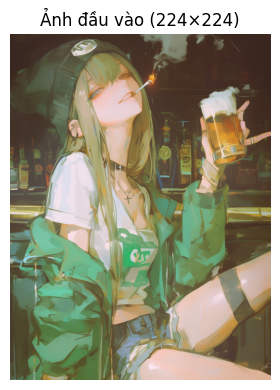

Input tensor shape: torch.Size([1, 3, 224, 224])
Tensor range: [-1.37, 2.43] (ImageNet-normalized)


In [ ]:
from io import BytesIO

import requests
from PIL import UnidentifiedImageError


def prepare_image(img_path=None, img_size=224):
    """
    Chuẩn bị ảnh cho MAE.
    Normalize theo ImageNet mean/std (khớp với cách model được train).
    """
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])
    
    if img_path:
        if img_path.startswith("http"):
            response = requests.get(
                img_path,
                timeout=15,
                headers={"User-Agent": "Mozilla/5.0"}
            )
            response.raise_for_status()
            content_type = response.headers.get("Content-Type", "")
            if "image" not in content_type.lower():
                raise ValueError(
                    f"URL không trả về ảnh hợp lệ. Content-Type nhận được: {content_type}"
                )
            try:
                img = Image.open(BytesIO(response.content)).convert("RGB")
            except UnidentifiedImageError as err:
                raise ValueError(
                    "Dữ liệu tải về không phải file ảnh hợp lệ (có thể URL hết hạn/chặn hotlink)."
                ) from err
        else:
            img = Image.open(img_path).convert('RGB')
    else:
        # Tạo ảnh gradient đẹp để demo
        x = np.linspace(0, 1, img_size)
        y = np.linspace(0, 1, img_size)
        xx, yy = np.meshgrid(x, y)
        
        r = np.sin(xx * 3 * np.pi) * 0.5 + 0.5
        g = np.cos(yy * 3 * np.pi) * 0.5 + 0.5
        b = np.sin((xx + yy) * 2 * np.pi) * 0.5 + 0.5
        
        img_array = np.stack([r, g, b], axis=-1)
        img_array = (img_array * 255).astype(np.uint8)
        img = Image.fromarray(img_array)
    
    tensor = transform(img).unsqueeze(0)  # (1, 3, 224, 224)
    return img, tensor

# Ưu tiên ảnh fox gốc từ demo official MAE (ILSVRC2012_val_00046145)
image_candidates = [
    'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg',
    'https://cdn.imgchest.com/files/7eb39115dd89.JPEG',
]

img, img_tensor = None, None
for candidate in image_candidates:
    try:
        img, img_tensor = prepare_image(candidate)
        print(f"✅ Loaded image from: {candidate}")
        break
    except Exception as e:
        print(f"⚠️ Không load được {candidate}: {e}")

if img is None:
    print("⚠️ Dùng ảnh synthetic vì tất cả URL đều lỗi.")
    img, img_tensor = prepare_image()

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title('Ảnh đầu vào (224×224)', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()
print(f"Input tensor shape: {img_tensor.shape}")
print(f"Tensor range: [{img_tensor.min():.2f}, {img_tensor.max():.2f}] (ImageNet-normalized)")

## 3. Visualize quá trình Masking & Reconstruction

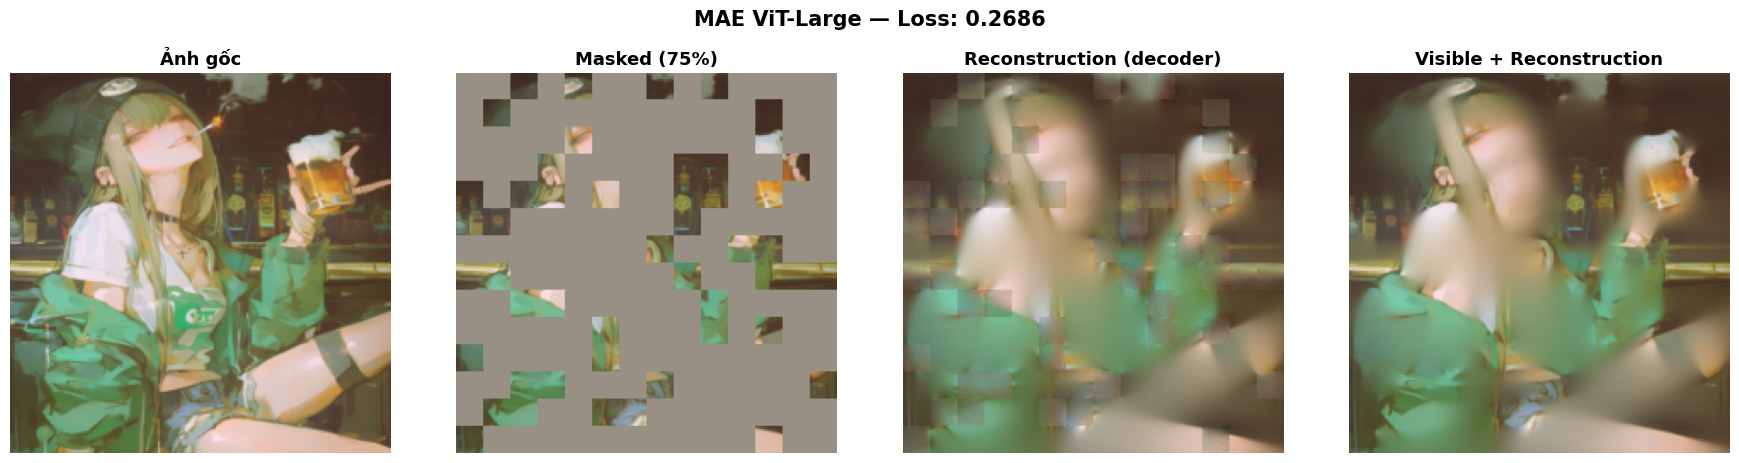


📊 Reconstruction loss (MSE): 0.2686


In [13]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def visualize_mae(model, img_tensor, mask_ratio=0.75):
    """
    Chạy MAE và visualize:
    1. Ảnh gốc
    2. Ảnh masked (75% patches bị che)
    3. Reconstruction (output decoder)
    4. Reconstruction + visible patches
    """
    model.eval()
    with torch.no_grad():
        # Forward pass
        loss, pred, mask = model(img_tensor, mask_ratio=mask_ratio)
        
        # Patchify ảnh gốc để so sánh
        target = model.patchify(img_tensor)  # (1, 196, 768)
        
        # Tạo ảnh masked (chỉ giữ visible patches)
        masked_img = target.clone()
        # mask=1 nghĩa là bị che → set về 0.5 (xám)
        mask_expanded = mask.unsqueeze(-1).expand_as(masked_img)
        masked_img[mask_expanded.bool()] = 0.5
        masked_img = model.unpatchify(masked_img)  # (1, 3, 224, 224)
        
        # Reconstruction: thay masked patches bằng prediction
        reconstruction = target.clone()
        reconstruction[mask_expanded.bool()] = pred[mask_expanded.bool()]
        reconstruction = model.unpatchify(reconstruction)  # (1, 3, 224, 224)
        
        # Full prediction (chỉ từ decoder)
        pred_img = model.unpatchify(pred)  # (1, 3, 224, 224)
    
    # Visualize — denormalize nếu input đã normalize theo ImageNet
    fig, axes = plt.subplots(1, 4, figsize=(18, 4.5))
    titles = [
        'Ảnh gốc',
        f'Masked ({mask_ratio:.0%})',
        'Reconstruction (decoder)',
        'Visible + Reconstruction'
    ]
    images = [
        img_tensor[0],
        masked_img[0],
        pred_img[0],
        reconstruction[0]
    ]
    
    for ax, title, image in zip(axes, titles, images):
        # Denormalize: undo ImageNet normalization for display
        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = img_np * imagenet_std + imagenet_mean
        img_np = np.clip(img_np, 0, 1)
        ax.imshow(img_np)
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.axis('off')
    
    fig.suptitle(f'MAE ViT-Large — Loss: {loss.item():.4f}', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return loss.item()

loss = visualize_mae(model, img_tensor, mask_ratio=0.75)
print(f"\n📊 Reconstruction loss (MSE): {loss:.4f}")

### Thử các mask ratio khác nhau

Thử các mask ratio khác nhau:


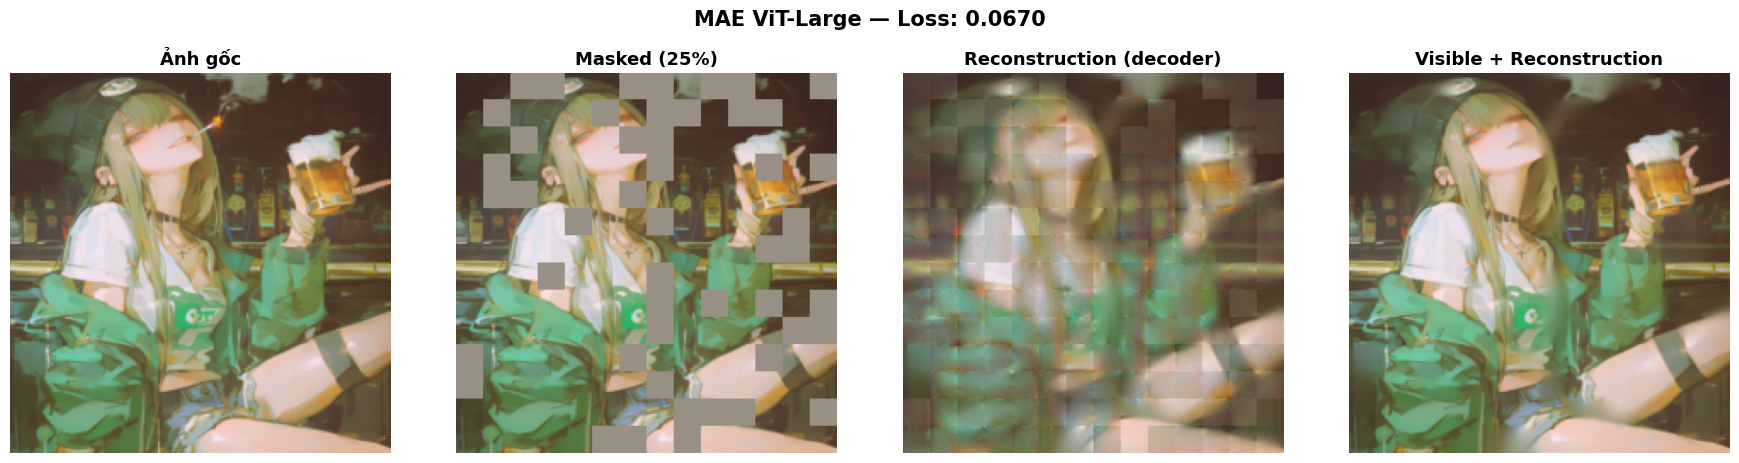

   Mask ratio 25%: Loss = 0.0670


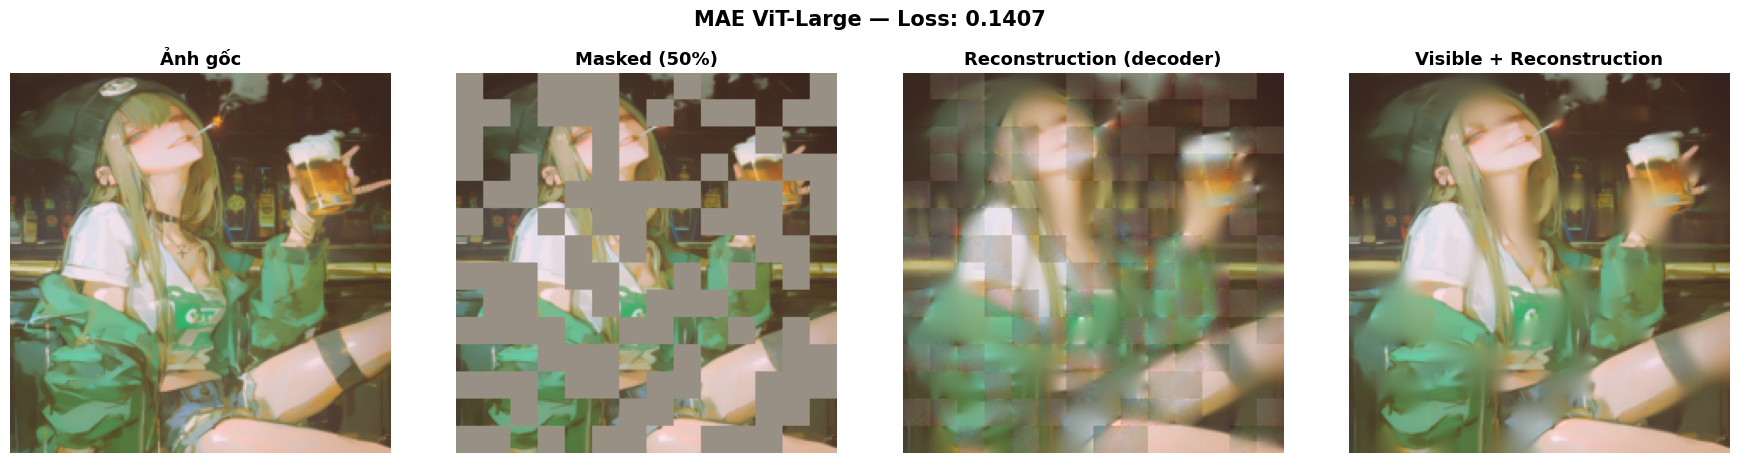

   Mask ratio 50%: Loss = 0.1407


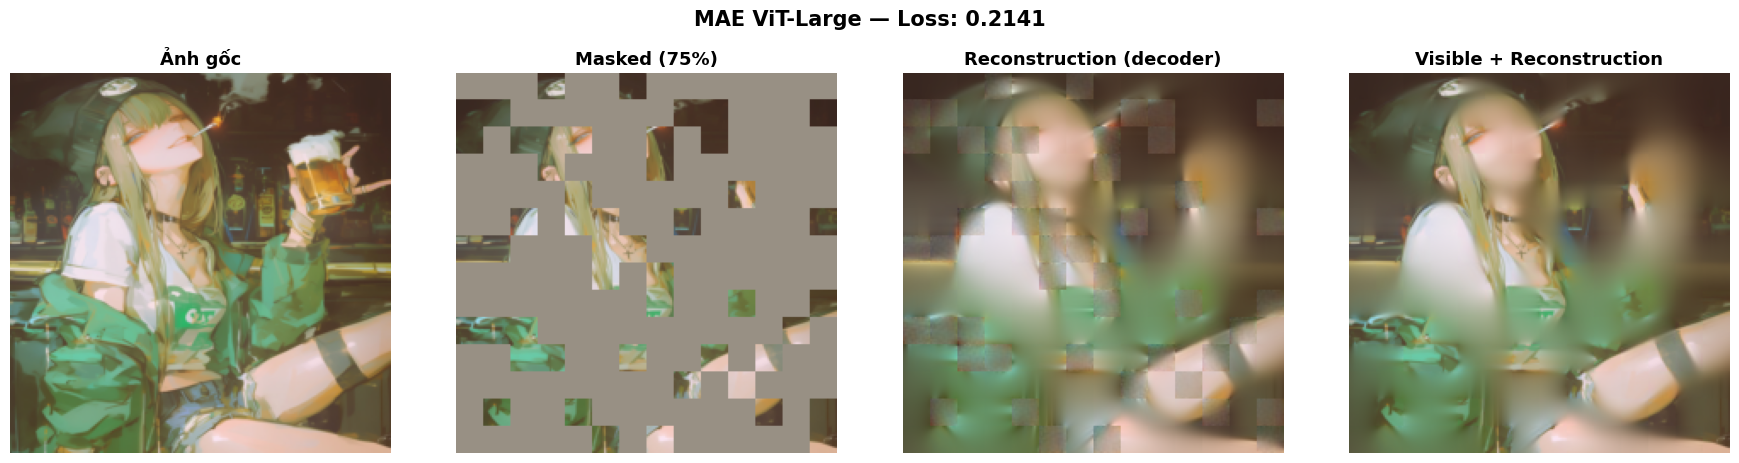

   Mask ratio 75%: Loss = 0.2141


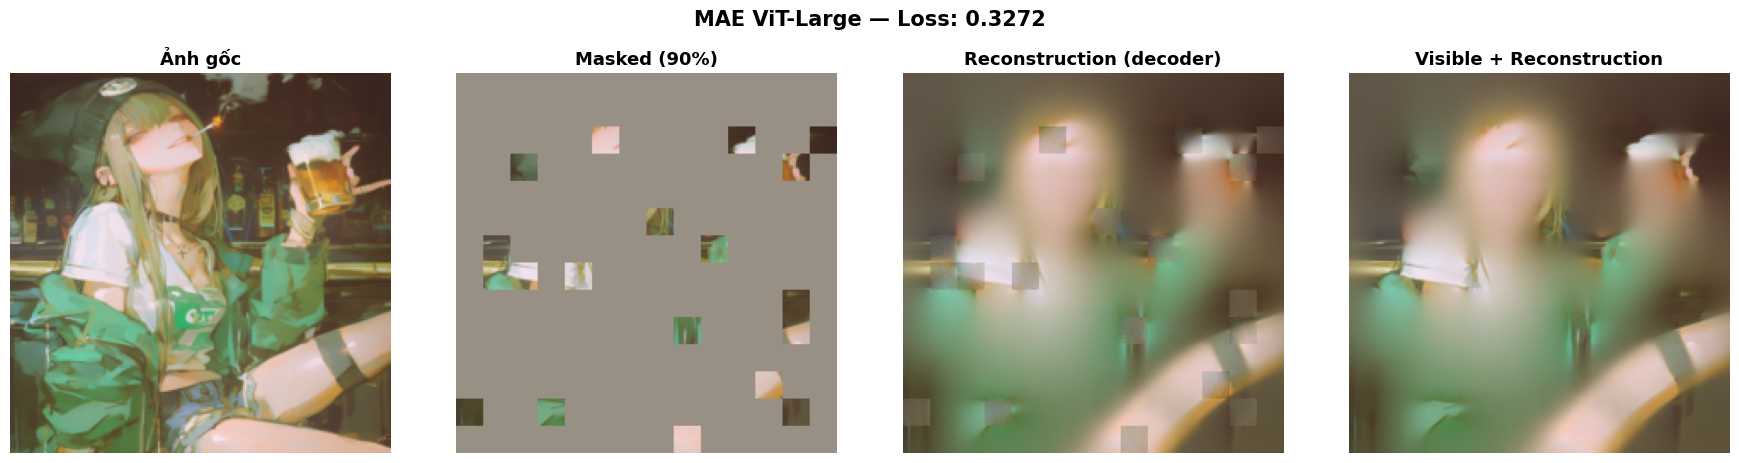

   Mask ratio 90%: Loss = 0.3272


In [14]:
print("Thử các mask ratio khác nhau:")
print("=" * 50)
for ratio in [0.25, 0.50, 0.75, 0.90]:
    loss = visualize_mae(model, img_tensor, mask_ratio=ratio)
    print(f"   Mask ratio {ratio:.0%}: Loss = {loss:.4f}")

## 4. Visualize Mask Pattern

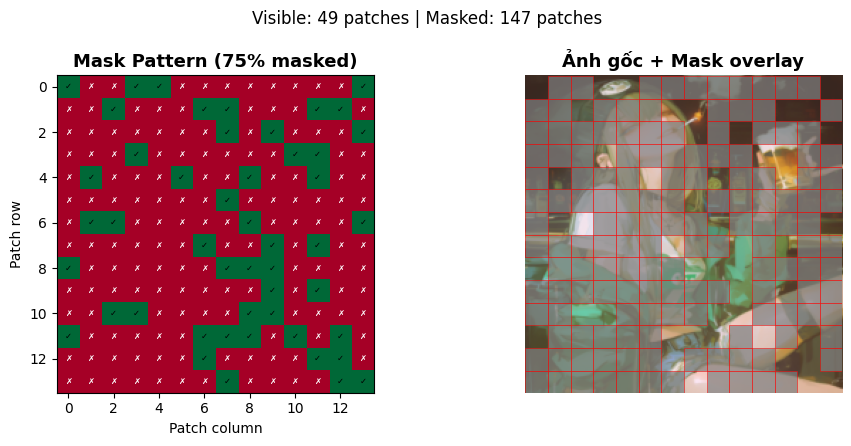

In [16]:
def visualize_mask_pattern(model, img_tensor, mask_ratio=0.75):
    """Visualize mask pattern trên grid 14×14."""
    model.eval()
    with torch.no_grad():
        _, mask, _ = model.forward_encoder(img_tensor, mask_ratio)
    
    # Reshape mask thành grid 14×14
    mask_grid = mask[0].reshape(14, 14).cpu().numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
    
    # Mask pattern
    axes[0].imshow(mask_grid, cmap='RdYlGn_r', vmin=0, vmax=1)
    axes[0].set_title(f'Mask Pattern ({mask_ratio:.0%} masked)', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Patch column')
    axes[0].set_ylabel('Patch row')
    for i in range(14):
        for j in range(14):
            text = '✗' if mask_grid[i, j] > 0.5 else '✓'
            axes[0].text(j, i, text, ha='center', va='center', fontsize=6,
                        color='white' if mask_grid[i, j] > 0.5 else 'black')
    
    # Ảnh gốc với overlay — denormalize for display
    img_np = img_tensor[0].permute(1, 2, 0).cpu().numpy()
    img_np = img_np * imagenet_std + imagenet_mean
    img_np = np.clip(img_np, 0, 1)
    axes[1].imshow(img_np)
    # Overlay masked patches
    for i in range(14):
        for j in range(14):
            if mask_grid[i, j] > 0.5:
                rect = plt.Rectangle(
                    (j * 16, i * 16), 16, 16,
                    linewidth=0.5, edgecolor='red',
                    facecolor='gray', alpha=0.7
                )
                axes[1].add_patch(rect)
    axes[1].set_title('Ảnh gốc + Mask overlay', fontsize=13, fontweight='bold')
    axes[1].axis('off')
    
    visible = int((1 - mask_ratio) * 196)
    masked = 196 - visible
    fig.suptitle(f'Visible: {visible} patches | Masked: {masked} patches', fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_mask_pattern(model, img_tensor, mask_ratio=0.75)

## 5. Model Monitoring & Kiến trúc

In [17]:
def model_summary(model):
    """In tóm tắt kiến trúc model."""
    print("=" * 70)
    print("  MAE ViT-Large — Model Summary")
    print("=" * 70)
    
    # Thống kê params
    total_params = 0
    trainable_params = 0
    
    encoder_params = 0
    decoder_params = 0
    
    print(f"\n{'Layer':<45} {'Shape':<25} {'Params':>12}")
    print("-" * 82)
    
    for name, param in model.named_parameters():
        params = param.numel()
        total_params += params
        if param.requires_grad:
            trainable_params += params
        
        is_decoder = any(name.startswith(p) for p in ['decoder_', 'mask_token'])
        if is_decoder:
            decoder_params += params
        else:
            encoder_params += params
        
        # Chỉ in các layer chính (không in từng block)
        if any(name.startswith(p) for p in [
            'cls_token', 'patch_embed', 'norm.', 
            'decoder_embed', 'mask_token', 'decoder_norm', 'decoder_pred',
            'blocks.0.', 'blocks.23.', 'decoder_blocks.0.', 'decoder_blocks.7.'
        ]):
            shape_str = str(list(param.shape))
            print(f"  {name:<43} {shape_str:<25} {params:>12,}")
    
    print(f"  {'...':<43} {'(blocks 1-22, decoder 1-6)':<25}")
    
    print("-" * 82)
    print(f"\n📊 Tổng kết:")
    print(f"   Total params:     {total_params:>15,} ({total_params/1e6:.1f}M)")
    print(f"   Trainable params: {trainable_params:>15,} ({trainable_params/1e6:.1f}M)")
    print(f"   Encoder params:   {encoder_params:>15,} ({encoder_params/1e6:.1f}M)")
    print(f"   Decoder params:   {decoder_params:>15,} ({decoder_params/1e6:.1f}M)")
    
    return total_params, encoder_params, decoder_params

total, enc, dec = model_summary(model)

  MAE ViT-Large — Model Summary

Layer                                         Shape                           Params
----------------------------------------------------------------------------------
  cls_token                                   [1, 1, 1024]                     1,024
  mask_token                                  [1, 1, 512]                        512
  patch_embed.proj.weight                     [1024, 3, 16, 16]              786,432
  patch_embed.proj.bias                       [1024]                           1,024
  blocks.0.norm1.weight                       [1024]                           1,024
  blocks.0.norm1.bias                         [1024]                           1,024
  blocks.0.attn.qkv.weight                    [3072, 1024]                 3,145,728
  blocks.0.attn.qkv.bias                      [3072]                           3,072
  blocks.0.attn.proj.weight                   [1024, 1024]                 1,048,576
  blocks.0.attn.proj.bias         

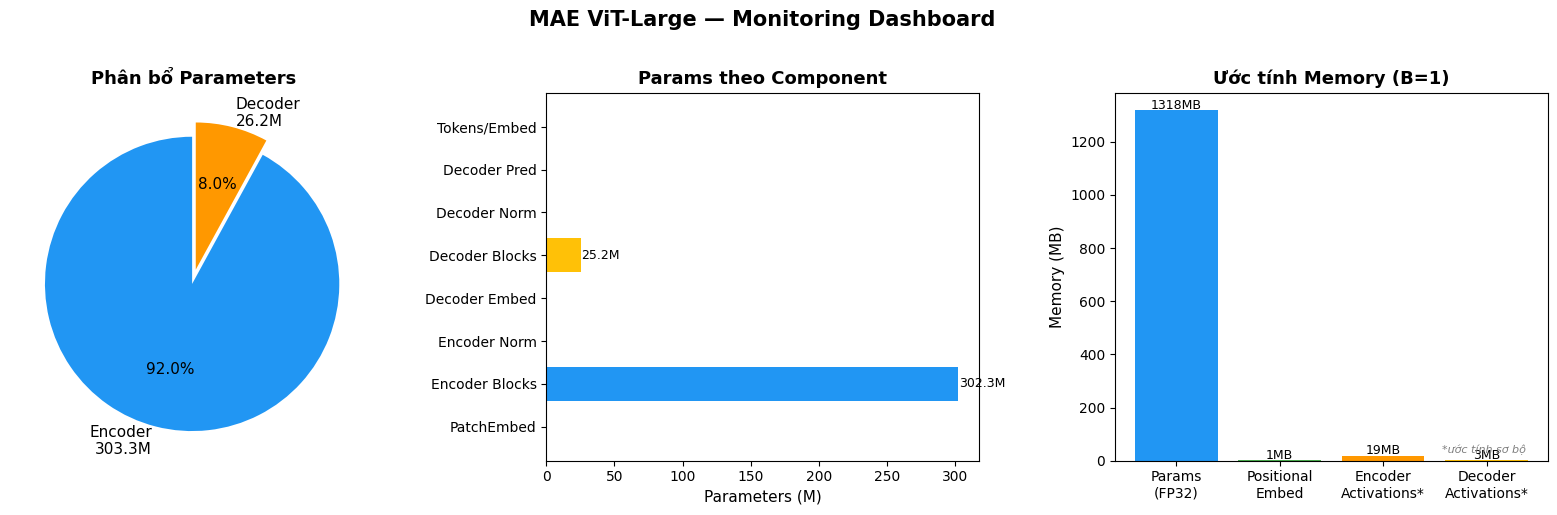

In [18]:
def monitoring_chart(model):
    """Biểu đồ monitoring: phân bổ params, memory."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # --- Chart 1: Phân bổ params encoder vs decoder ---
    enc_params = sum(
        p.numel() for n, p in model.named_parameters()
        if not any(n.startswith(pf) for pf in ['decoder_', 'mask_token'])
    )
    dec_params = sum(
        p.numel() for n, p in model.named_parameters()
        if any(n.startswith(pf) for pf in ['decoder_', 'mask_token'])
    )
    
    labels = [f'Encoder\n{enc_params/1e6:.1f}M', f'Decoder\n{dec_params/1e6:.1f}M']
    sizes = [enc_params, dec_params]
    colors = ['#2196F3', '#FF9800']
    explode = (0.05, 0.05)
    
    axes[0].pie(sizes, labels=labels, colors=colors, explode=explode,
                autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
    axes[0].set_title('Phân bổ Parameters', fontsize=13, fontweight='bold')
    
    # --- Chart 2: Params theo component ---
    components = {
        'PatchEmbed': 0, 'Encoder Blocks': 0, 'Encoder Norm': 0,
        'Decoder Embed': 0, 'Decoder Blocks': 0, 'Decoder Norm': 0,
        'Decoder Pred': 0, 'Tokens/Embed': 0
    }
    for name, param in model.named_parameters():
        n = param.numel()
        if name.startswith('patch_embed'):
            components['PatchEmbed'] += n
        elif name.startswith('blocks.'):
            components['Encoder Blocks'] += n
        elif name.startswith('norm.'):
            components['Encoder Norm'] += n
        elif name.startswith('decoder_embed'):
            components['Decoder Embed'] += n
        elif name.startswith('decoder_blocks'):
            components['Decoder Blocks'] += n
        elif name.startswith('decoder_norm'):
            components['Decoder Norm'] += n
        elif name.startswith('decoder_pred'):
            components['Decoder Pred'] += n
        else:
            components['Tokens/Embed'] += n
    
    comp_names = list(components.keys())
    comp_values = [v / 1e6 for v in components.values()]
    bar_colors = ['#4CAF50', '#2196F3', '#03A9F4', 
                  '#FF9800', '#FFC107', '#FFE082', '#FFF3E0', '#9E9E9E']
    
    bars = axes[1].barh(comp_names, comp_values, color=bar_colors)
    axes[1].set_xlabel('Parameters (M)', fontsize=11)
    axes[1].set_title('Params theo Component', fontsize=13, fontweight='bold')
    for bar, val in zip(bars, comp_values):
        if val > 1:
            axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                        f'{val:.1f}M', va='center', fontsize=9)
    
    # --- Chart 3: Memory estimation ---
    param_memory = sum(p.numel() * p.element_size() for p in model.parameters()) / 1e6
    buffer_memory = sum(b.numel() * b.element_size() for b in model.buffers()) / 1e6
    # Positional embeds (non-learnable params)
    pos_memory = (model.pos_embed.numel() + model.decoder_pos_embed.numel()) * 4 / 1e6
    
    # Ước tính activation memory (batch_size=1, fp32)
    # Encoder: 196 * 1024 * 24 blocks * 4 bytes
    # Decoder: 197 * 512 * 8 blocks * 4 bytes
    enc_act = 196 * 1024 * 24 * 4 / 1e6
    dec_act = 197 * 512 * 8 * 4 / 1e6
    
    mem_labels = ['Params\n(FP32)', 'Positional\nEmbed', 'Encoder\nActivations*', 'Decoder\nActivations*']
    mem_values = [param_memory, pos_memory, enc_act, dec_act]
    mem_colors = ['#2196F3', '#4CAF50', '#FF9800', '#FFC107']
    
    bars = axes[2].bar(mem_labels, mem_values, color=mem_colors)
    axes[2].set_ylabel('Memory (MB)', fontsize=11)
    axes[2].set_title('Ước tính Memory (B=1)', fontsize=13, fontweight='bold')
    for bar, val in zip(bars, mem_values):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'{val:.0f}MB', ha='center', fontsize=9)
    axes[2].annotate('*ước tính sơ bộ', xy=(0.95, 0.02), xycoords='axes fraction',
                     fontsize=8, ha='right', fontstyle='italic', color='gray')
    
    plt.suptitle('MAE ViT-Large — Monitoring Dashboard', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

monitoring_chart(model)

## 6. Encoder Feature Analysis

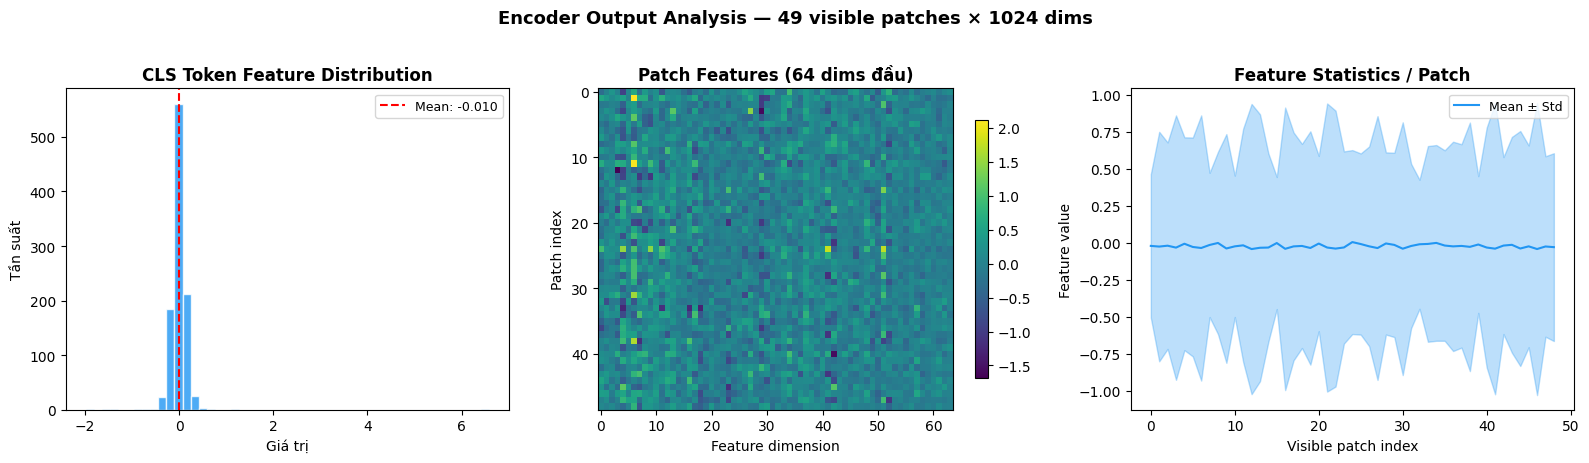


📊 Encoder output shape: torch.Size([1, 50, 1024])
   CLS token: mean=-0.0101, std=0.2799
   Patches:   mean=-0.0227, std=0.7302


In [9]:
def analyze_encoder_features(model, img_tensor):
    """Phân tích features từ encoder."""
    model.eval()
    with torch.no_grad():
        # Forward encoder
        latent, mask, ids_restore = model.forward_encoder(img_tensor, mask_ratio=0.75)
    
    # latent: (1, 50, 1024) — 49 visible patches + 1 CLS
    cls_token = latent[0, 0, :]  # (1024,)
    patch_features = latent[0, 1:, :]  # (49, 1024)
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
    
    # Chart 1: CLS token distribution
    axes[0].hist(cls_token.cpu().numpy(), bins=50, color='#2196F3', alpha=0.8, edgecolor='white')
    axes[0].set_title('CLS Token Feature Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Giá trị')
    axes[0].set_ylabel('Tần suất')
    axes[0].axvline(cls_token.mean().item(), color='red', linestyle='--', label=f'Mean: {cls_token.mean():.3f}')
    axes[0].legend(fontsize=9)
    
    # Chart 2: Feature heatmap (first 64 dims of all patches)
    heatmap_data = patch_features[:, :64].cpu().numpy()
    im = axes[1].imshow(heatmap_data, aspect='auto', cmap='viridis')
    axes[1].set_title('Patch Features (64 dims đầu)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Feature dimension')
    axes[1].set_ylabel('Patch index')
    plt.colorbar(im, ax=axes[1], shrink=0.8)
    
    # Chart 3: Feature statistics per patch
    patch_means = patch_features.mean(dim=-1).cpu().numpy()
    patch_stds = patch_features.std(dim=-1).cpu().numpy()
    x = range(len(patch_means))
    axes[2].fill_between(x, patch_means - patch_stds, patch_means + patch_stds, alpha=0.3, color='#2196F3')
    axes[2].plot(x, patch_means, color='#2196F3', linewidth=1.5, label='Mean ± Std')
    axes[2].set_title('Feature Statistics / Patch', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Visible patch index')
    axes[2].set_ylabel('Feature value')
    axes[2].legend(fontsize=9)
    
    plt.suptitle(f'Encoder Output Analysis — {patch_features.shape[0]} visible patches × {patch_features.shape[1]} dims',
                fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Encoder output shape: {latent.shape}")
    print(f"   CLS token: mean={cls_token.mean():.4f}, std={cls_token.std():.4f}")
    print(f"   Patches:   mean={patch_features.mean():.4f}, std={patch_features.std():.4f}")

analyze_encoder_features(model, img_tensor)

## 7. Tóm tắt

In [19]:
print("\n" + "=" * 60)
print("  📋 TÓM TẮT MAE ViT-Large")
print("=" * 60)
print(f"")
print(f"  Bài báo:     Masked Autoencoders Are Scalable Vision Learners")
print(f"  Tác giả:     He, Chen, Xie, Li, Dollár, Girshick (2022)")
print(f"  Kiến trúc:   ViT-Large (24 blocks, 1024-dim, 16 heads)")
print(f"  LayerNorm:   eps=1e-6 (khớp official implementation)")
print(f"  Checkpoint:  mae_visualize_vit_large.pth (full, 398 keys)")
print(f"")
print(f"  Encoder:     {sum(p.numel() for n, p in model.named_parameters() if not any(n.startswith(pf) for pf in ['decoder_', 'mask_token'])) / 1e6:.1f}M params")
print(f"  Decoder:     {sum(p.numel() for n, p in model.named_parameters() if any(n.startswith(pf) for pf in ['decoder_', 'mask_token'])) / 1e6:.1f}M params")
print(f"  Total:       {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M params")
print(f"")
print(f"  Input:       (B, 3, 224, 224) — ImageNet-normalized")
print(f"  Patches:     196 = 14×14 (patch_size=16)")
print(f"  Mask ratio:  75% (147 masked, 49 visible)")
print(f"")
print(f"  Checkpoints từ Facebook:")
print(f"    Full (reconstruction): mae_visualize_vit_large.pth  (398 keys)")
print(f"    Encoder (fine-tuning): mae_pretrain_vit_large.pth   (294 keys)")
print(f"")
print("=" * 60)
print("  ✅ Model sẵn sàng cho reconstruction & fine-tuning!")
print("=" * 60)


  📋 TÓM TẮT MAE ViT-Large

  Bài báo:     Masked Autoencoders Are Scalable Vision Learners
  Tác giả:     He, Chen, Xie, Li, Dollár, Girshick (2022)
  Kiến trúc:   ViT-Large (24 blocks, 1024-dim, 16 heads)
  LayerNorm:   eps=1e-6 (khớp official implementation)
  Checkpoint:  mae_visualize_vit_large.pth (full, 398 keys)

  Encoder:     303.3M params
  Decoder:     26.2M params
  Total:       329.5M params

  Input:       (B, 3, 224, 224) — ImageNet-normalized
  Patches:     196 = 14×14 (patch_size=16)
  Mask ratio:  75% (147 masked, 49 visible)

  Checkpoints từ Facebook:
    Full (reconstruction): mae_visualize_vit_large.pth  (398 keys)
    Encoder (fine-tuning): mae_pretrain_vit_large.pth   (294 keys)

  ✅ Model sẵn sàng cho reconstruction & fine-tuning!
